/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch   1 | train 1.0675 | val 0.9987 | acc 54.23%
Epoch   2 | train 0.9863 | val 0.9557 | acc 58.99%
Epoch   3 | train 0.9368 | val 0.9291 | acc 60.58%
Epoch   4 | train 0.8982 | val 0.9004 | acc 65.08%
Epoch   5 | train 0.8413 | val 0.8630 | acc 65.61%
Epoch   6 | train 0.8062 | val 0.8515 | acc 66.67%
Epoch   7 | train 0.7954 | val 0.8524 | acc 64.02%
Epoch   8 | train 0.7795 | val 0.8930 | acc 64.81%
Epoch   9 | train 0.7588 | val 0.8425 | acc 64.29%
Epoch  10 | train 0.7453 | val 0.8719 | acc 62.70%
Epoch  11 | train 0.7236 | val 0.8506 | acc 65.87%
Epoch  12 | train 0.7010 | val 0.8416 | acc 69.05%
Epoch  13 | train 0.6669 | val 0.8746 | acc 67.99%
Epoch  14 | train 0.6724 | val 0.8563 | acc 66.40%
Epoch  15 | train 0.6641 | val 0.8641 | acc 66.40%
Epoch  16 | train 0.6559 | val 0.8694 | acc 67.72%
Epoch  17 | train 0.6141 | val 0.8747 | acc 66.14%
Epoch  18 | train 0.6251 | val 0.8903 | acc 67.99%
Epoch  19 | train 0.5778 | val 0.8939 | acc 67.20%
Epoch  20 | train 0.5677 | val 

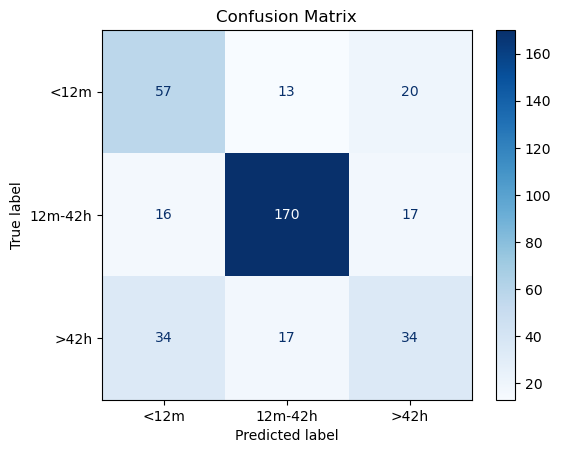

In [ ]:
# 1)importing libraries
import numpy as np
import pandas as pd
import random, os, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

def seed_everything(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True

def get_class_weights(y):
    """Inverse-frequency class weights for CrossEntropyLoss."""
    class_counts = np.bincount(y)
    total = len(y)
    return torch.tensor([total / c for c in class_counts], dtype=torch.float)

seed_everything(42)

# 2)loading and labeling the dataset
# defining quantiles for half-life
df = pd.read_csv("/Users/ozgetimur/Desktop/halfpepstab/pepdist_final.csv")

def categorize_half_life(h):
    return 0 if h < 12 else (1 if h < 2_500 else 2)

df["stability_class"] = df["half_life"].apply(categorize_half_life)

peptides = df["peptide_seq"].values                   # shape (N,)
y        = df["stability_class"].values               # shape (N,)
dist_cols = [c for c in df.columns if c.startswith("dist_")]
dist_mat  = df[dist_cols].values.astype(np.float32)   # shape (N, D)

# 3)encoding peptides
AA_ORDER = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_IDX = {aa: i for i, aa in enumerate(AA_ORDER)}

def one_hot(seq):
    enc = np.zeros((len(seq), len(AA_ORDER)), dtype=np.float32)
    for i, aa in enumerate(seq):
        if aa in AA_TO_IDX:
            enc[i, AA_TO_IDX[aa]] = 1.0
    return enc.flatten()          # 9×20 = 180 for a 9-mer

pept_mat = np.stack([one_hot(s) for s in peptides])   # shape (N, 180)

# 4)train/test split
# stratified split to maintain class distribution
(X_pep_tr, X_pep_te,
 X_dist_tr_raw, X_dist_te_raw,
 y_tr, y_te) = train_test_split(
        pept_mat, dist_mat, y,
        test_size=0.20, stratify=y, random_state=42)

# 5) Scaling distances (train-only fit) 
scaler = StandardScaler()
X_dist_tr = scaler.fit_transform(X_dist_tr_raw)
X_dist_te = scaler.transform(X_dist_te_raw)

# 6) PyTorch Dataset & DataLoader 
class PMHCDataset(Dataset):
    def __init__(self, pep, dist, labels):
        self.pep = torch.from_numpy(pep).float()
        self.dist = torch.from_numpy(dist).float()
        self.labels = torch.from_numpy(labels).long()
    def __len__(self):  return len(self.labels)
    def __getitem__(self, idx):
        return {"peptide": self.pep[idx],
                "distances": self.dist[idx],
                "label": self.labels[idx]}

train_loader = DataLoader(PMHCDataset(X_pep_tr, X_dist_tr, y_tr),
                          batch_size=32, shuffle=True)
val_loader   = DataLoader(PMHCDataset(X_pep_te, X_dist_te, y_te),
                          batch_size=32)

# 7)Model definition 
class PMHCStabilityModel(nn.Module):
    def __init__(self, pep_dim, dist_dim,
                 hidden=64, pos_emb_dim=8, num_classes=3):
        super().__init__()
        self.pos_emb = nn.Embedding(9, pos_emb_dim)   # 9 positions in a 9-mer

        pep_in = pep_dim + 9 * pos_emb_dim            # 180 + 72 = 252
        self.pep_net = nn.Sequential(
            nn.Linear(pep_in, hidden), nn.ReLU(), nn.Dropout(0.3))

        self.dist_net = nn.Sequential(
            nn.Linear(dist_dim, hidden), nn.ReLU(), nn.Dropout(0.3))

        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(hidden, num_classes))

    def forward(self, pep, dist):
        bsz = pep.size(0)
        # append positional embedding 
        pos_ids = torch.arange(9, device=pep.device).repeat(bsz, 1)
        pos_feat = self.pos_emb(pos_ids).view(bsz, -1)
        pep = torch.cat([pep, pos_feat], dim=1)
        
        out = torch.cat([self.pep_net(pep), self.dist_net(dist)], dim=1)
        return self.head(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PMHCStabilityModel(pep_dim=X_pep_tr.shape[1],
                           dist_dim=X_dist_tr.shape[1]).to(device)

# 8)Training loop (early stopping) 

criterion = nn.CrossEntropyLoss(weight=get_class_weights(y_tr).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.5, patience=5, verbose=False)
patience, best_val, wait = 15, float("inf"), 0

for epoch in range(1, 201):                           # up to 200 epochs
    #  train 
    model.train(); running = 0
    for batch in train_loader:
        optimizer.zero_grad()
        logits = model(batch["peptide"].to(device),
                       batch["distances"].to(device))
        loss = criterion(logits, batch["label"].to(device))
        loss.backward(); optimizer.step()
        running += loss.item()
    train_loss = running / len(train_loader)

    #  validate
    model.eval(); val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            logits = model(batch["peptide"].to(device),
                           batch["distances"].to(device))
            loss = criterion(logits, batch["label"].to(device))
            val_loss += loss.item()
            preds = logits.argmax(1).cpu()
            correct += (preds == batch["label"]).sum().item()
            total   += batch["label"].size(0)
    val_loss /= len(val_loader)
    val_acc  = correct / total * 100
    print(f"Epoch {epoch:3d} | train {train_loss:.4f} | "
          f"val {val_loss:.4f} | acc {val_acc:.2f}%")

    # scheduler & early stopping 
    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val, wait = val_loss, 0
        torch.save(model.state_dict(), "best_pmhc.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping! Best val loss:", best_val)
            break

#9) Evaluation 
model.load_state_dict(torch.load("best_pmhc.pt"))
model.eval(); preds, labels = [], []
with torch.no_grad():
    for batch in val_loader:
        logits = model(batch["peptide"].to(device),
                       batch["distances"].to(device))
        preds.extend(logits.argmax(1).cpu().numpy())
        labels.extend(batch["label"].numpy())

print("\nClassification report:\n",
      classification_report(labels, preds, digits=4))
print("Confusion matrix:\n", confusion_matrix(labels, preds))
# 10)Confusion matrix plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=["<12m", "12m-42h", ">42h"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()
